### Dimension Reduction Analysis

First run at the combination of embeddings into 2d space for easy visualization. 

* Single dataset (using common API to be easily swapped for any other choice of dataset)
* Group of algorithms
* Analysis of how the algorithms performed vs. each other
    * Visualization of the low dimensional space
    * Comparison via various quality measures
    

In [1]:
import os
from math import ceil

import pandas as pd
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE

from umap import UMAP

import src
import src.data.datasets as datasets
from src.visualization.plotting import two_dim_multiplot
import src.quality_measures as qm
import src.embedding_io as e_io
from src.paths import processed_data_path

import logging

LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
DATE_FORMAT = "%m/%d/%Y %I:%M:%S %p"

logging.basicConfig(format=LOG_FORMAT, datefmt=DATE_FORMAT, level=logging.INFO) 
logger = logging.getLogger()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# location to save data
if not processed_data_path.exists():
    os.makedirs(processed_data_path)

In [5]:
## To replace with data from the data directory
## Use small sample of MNIST included in sklearn for the toy example
dataset = datasets.load_dataset('coil-20')
dataset_name = 'COIL-20'
metric = 'euclidean'

high_data = dataset.data
labels = dataset.target

print(dataset.DESCR)

Columbia University Image Library (COIL-20)

Notes
-----
Data Set Characteristics:
    :Number of Instances: 1440
    :Number of Attributes: 49152
    :Attribute Information: 128x128 8-bit greyscale (PGM) image
    :Missing Attribute Values: None
    :Creator: Sameer A Nene, Shree K. Nayar and Hiroshi Murase
    :Date: 1995

This is a copy of the Columbia Object Image Library [COIL-20] data:
http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.tar.gz

This dataset consists of 1,440 greyscale images of 20 objects (72 images per object) where the objects
have been placed on a motorized turntable against a black background. Images were taken at 5 degree rotations,
giving 72 images per object. The resulting images were then size and intensity-normalized.

Size normalization involved first clipping to a rectangual bounding box and resized (with aspect
ratio preserved) to 128x128 using interpolation-decimation filters to minimize aliasing [Oppenheim and Schafe

## Choice of algorithms to use

Have them all set to use sklearn style API

* PCA
* MDS
* Isomap
* TSNE

In [6]:
low_dimension = 2

In [7]:
algorithms = {'PCA' : PCA(n_components=low_dimension, svd_solver='arpack'),
              'MDS' : MDS(n_components=low_dimension, metric=True),
              'Isomap' : Isomap(n_components=low_dimension),
              'tSNE' : TSNE(n_components=low_dimension)}

The next step takes approximately 
* Small MNIST: 2 minutes
* COIL-20: 8 minutes

In [8]:
low_data = {}
metadata = {}
for name, algorithm in algorithms.items():
    logger.info(f"Starting {name}")
    basefilename = "_".join([name, dataset_name.replace(' ', '-')])
    low_data[name], _, metadata[name] = e_io.create_embedding(basefilename, data=high_data, 
                                                              algorithm_object=algorithms[name], 
                                                              labels=labels, algorithm_name=name,
                                                              dataset_name=dataset_name,
                                                              data_path=processed_data_path)

INFO 07/04/2018 11:39:05 AM - Starting PCA
INFO 07/04/2018 11:39:05 AM - Existing metatdata file PCA_COIL-20_0.metadata found.
INFO 07/04/2018 11:39:05 AM - Desired embedding already exists. Loading from file...
INFO 07/04/2018 11:39:05 AM - Reading embedding PCA_COIL-20_0.embedding.npy
INFO 07/04/2018 11:39:05 AM - Starting MDS
INFO 07/04/2018 11:39:05 AM - Existing metatdata file MDS_COIL-20_0.metadata found.
INFO 07/04/2018 11:39:05 AM - Desired embedding already exists. Loading from file...
INFO 07/04/2018 11:39:05 AM - Reading embedding MDS_COIL-20_0.embedding.npy
INFO 07/04/2018 11:39:05 AM - Starting Isomap
INFO 07/04/2018 11:39:05 AM - Existing metatdata file Isomap_COIL-20_0.metadata found.
INFO 07/04/2018 11:39:05 AM - Desired embedding already exists. Loading from file...
INFO 07/04/2018 11:39:05 AM - Reading embedding Isomap_COIL-20_0.embedding.npy
INFO 07/04/2018 11:39:05 AM - Starting tSNE
INFO 07/04/2018 11:39:05 AM - Existing metatdata file tSNE_COIL-20_0.metadata found

## Visualization of the Embeddings

In [9]:
data = []
labels_list = [labels] * len(low_data)
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(k)

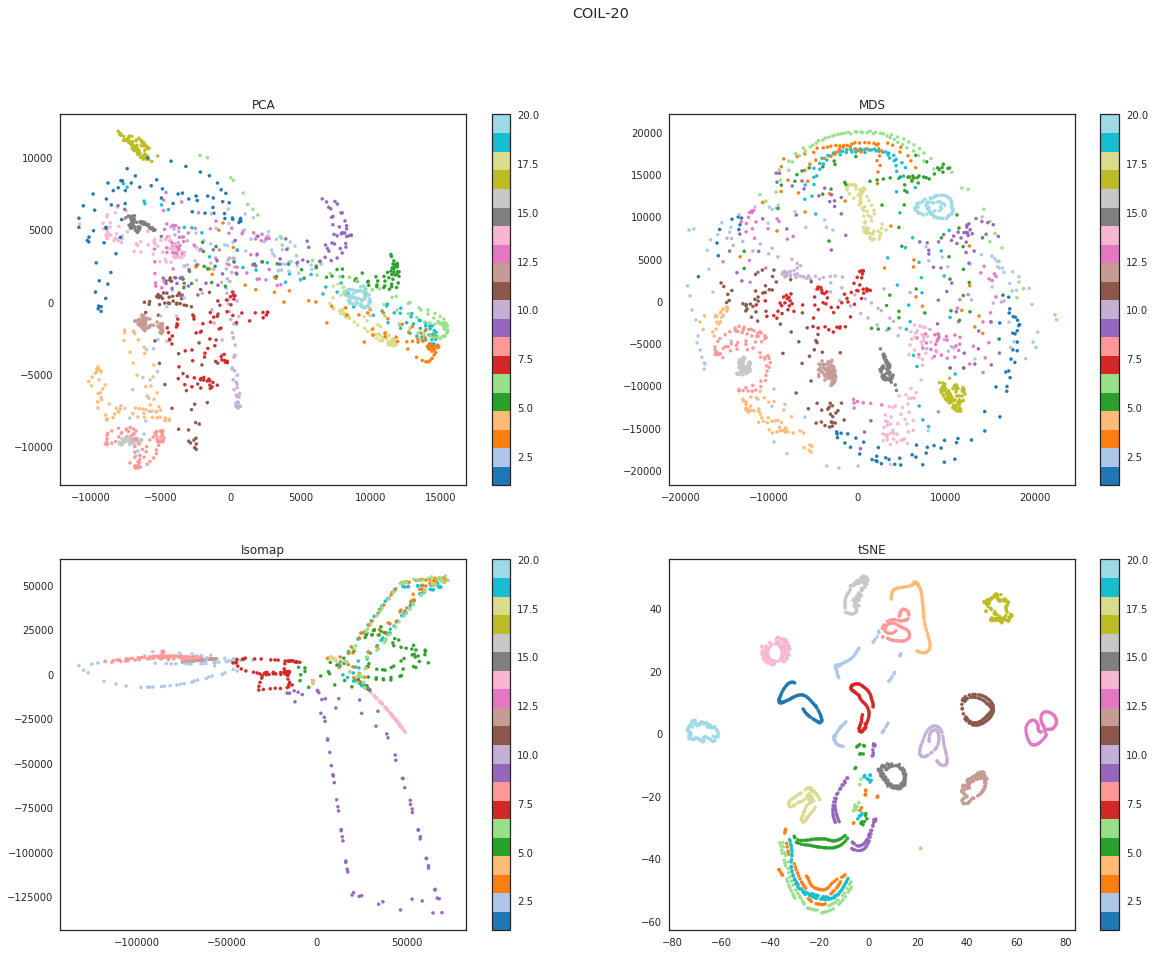

In [10]:
sns.set(style='white', rc={'figure.figsize':(20,15)})
two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="tab20", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Analysis via quality scores

Start by getting pairwise distances needed for both Stress and Strain.

In [11]:
high_distances = pairwise_distances(high_data, metric=metric)

In [12]:
%%time
low_distances_dict = {}
for name, data in low_data.items():
    _, low_distances, _ = qm.pairwise_distance_differences(high_distances=high_distances,
                                                           low_data=data, metric=metric)
    low_distances_dict[name] = low_distances

CPU times: user 142 ms, sys: 307 ms, total: 449 ms
Wall time: 118 ms


### Strain from Classical MDS
Strain is the name given to stress that is optimized in classical MDS. The optimal solution is given by PCA.

$$\textstyle Strain_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}{\frac {\sum _{i,j}{\bigl (}b_{ij}-\langle x_{i},x_{j}\rangle {\bigr )}^{2}}{\sum _{i,j}b_{ij}^{2}}}{\Biggr )}^{1/2}$$

where $B = -\frac{1}{2} J D^{(2)}J$ and $J = I_{N}-{\tfrac  {1}{N}}{\mathbf  {1}}{\mathbf  {1}}^{\top }$ where $\mathbf  {1}$ is the $N$-dimensional vector of 1's. 

#### Note: Only need to change the following two cells to get the analysis using a different quality score

In [13]:
score = 'Strain'

In [14]:
%%time
point_score = {}
total_score = {}
for name, low_distances in low_distances_dict.items():
    point_score[name] = qm.point_strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)
    total_score[name] = qm.strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)

CPU times: user 4.75 s, sys: 2.58 s, total: 7.33 s
Wall time: 1.93 s


### Visualization of the point score on the same scale
Color represents the value of the contribution of a given point towards the total score

In [15]:
data = []
labels_list = []
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(f"{k}\n {score}: {total_score[k]}")
    labels_list.append(point_score[k])

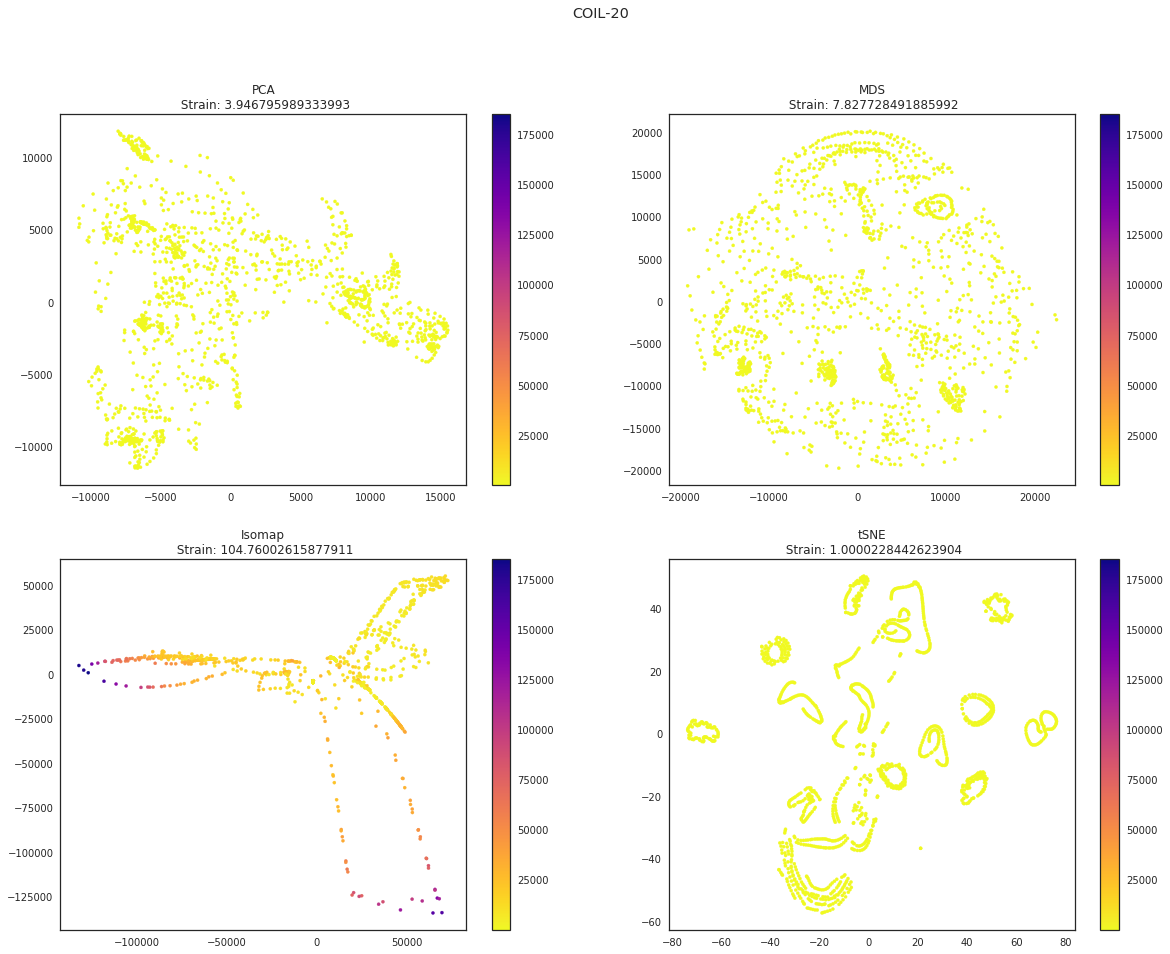

In [16]:
sns.set(style='white', rc={'figure.figsize':(20,15)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=True)
plt.suptitle(dataset_name);

### How about distributions

In [17]:
point_score_df = pd.DataFrame(point_score)

In [18]:
point_score_df.describe()

,PCA,MDS,Isomap,tSNE
count,1440.000000,1440.000000,1440.000000,1440.000000
mean,15.515096,70.608928,13701.798925,1.000045
std,3.206888,35.043921,19408.714097,0.000024
min,8.039995,31.337177,1889.004441,0.999979
25%,13.256844,47.770533,4063.206079,1.000034
50%,15.523926,57.975959,7355.037826,1.000047
75%,17.829600,81.211646,16494.468353,1.000057
max,30.230063,292.147548,184917.344089,1.000141


/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg

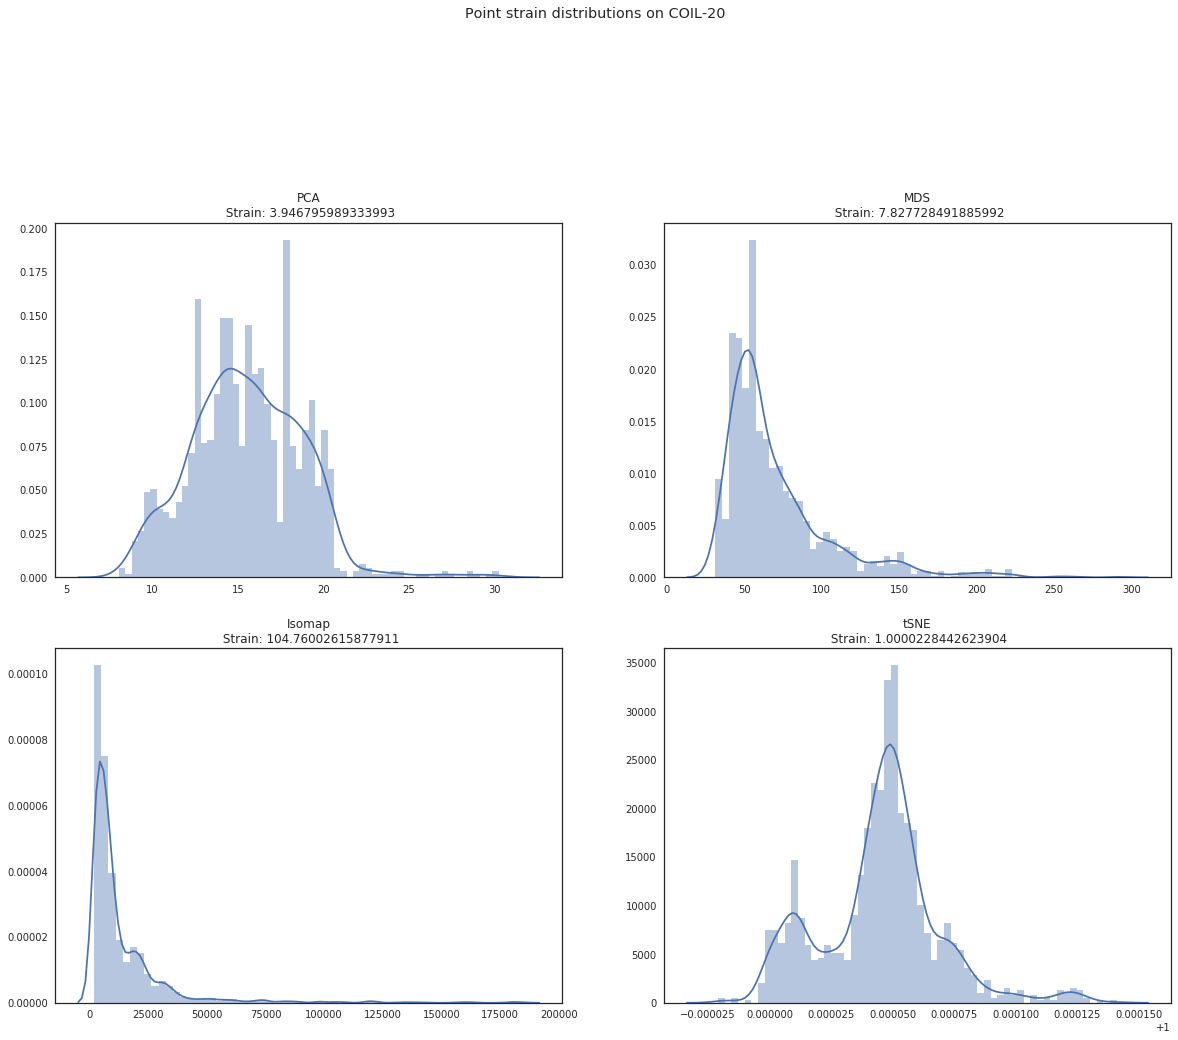

In [19]:
sns.set(style='white', rc={'figure.figsize':(20,30)})

plot_num = 1
ncols = 2
nrows = ceil(len(point_score))

for name, p_score in point_score.items():
    plt.subplot(nrows, ncols, plot_num)
    plot_num += 1
    plt.title(f"{name}\n {score}: {total_score[name]}")
    sns.distplot(p_score, bins=60)
plt.suptitle(f"Point {score.lower()} distributions on {dataset_name}");

### With different colorbar scales

Here we can see where the distrubutions lie with respect to the reduction

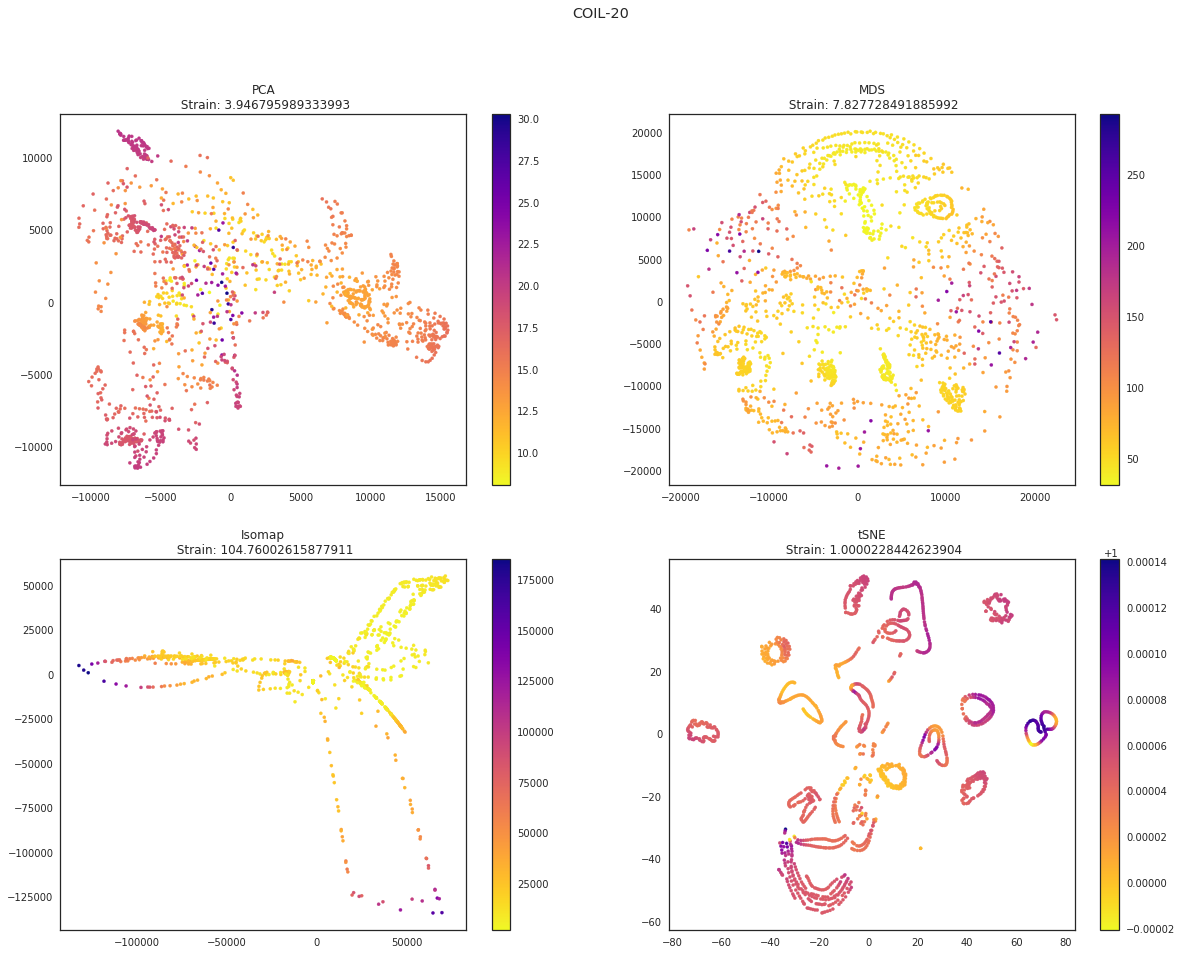

In [20]:
sns.set(style='white', rc={'figure.figsize':(20,15)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Are the same points contributing to the high values in all cases?

In [21]:
n_worst_points = 100

In [22]:
worst_scoring_points = {}
for name, p_score in point_score.items():
    a = point_score_df[name]
    worst_scoring_points[name] = np.argpartition(a, -1 * n_worst_points)[-1 * n_worst_points:]

In [23]:
shared_points_idx = set(point_score_df.index)
for name, worst_points in worst_scoring_points.items():
    shared_points_idx.intersection_update(worst_points)
shared_points_idx = list(shared_points_idx)
len(shared_points_idx)

0

In [24]:
point_score_df.iloc[shared_points_idx]

,PCA,MDS,Isomap,tSNE


In [25]:
# Note that there is overlap if we take stress instead of strain with COIL-20